In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, List
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
import os
import sqlite3
import pandas as pd
import pickle

In [10]:
def visualize_trajectories(
    trajectories: torch.Tensor,
    dweights: torch.Tensor = None,
    robustness_values: Optional[torch.Tensor] = None,
    base_trajectory: Optional[torch.Tensor] = None,
    alpha_range: tuple = (0.0, 1.0),
) -> None:
    """
    Visualize trajectories with time evolution for each dimension.
    
    Parameters:
    -----------
    trajectories : torch.Tensor
        Tensor of shape (n_trajectories, n_vars n_points) containing the trajectories
    robustness_values : Optional[torch.Tensor]
        Tensor of shape (n_trajectories,) containing robustness values for each trajectory
    base_trajectory : Optional[torch.Tensor]
        Optional tensor of shape (1, n_points, n_vars) containing a base trajectory to highlight
    title : str
        Title for the plot
    alpha_range : tuple
        Range of alpha values for transparency (min, max)
    colormap : str
        Matplotlib colormap to use for the trajectories
    figsize : tuple
        Figure size in inches
    time_points : Optional[torch.Tensor]
        Optional tensor of time points. If None, uses range(n_points)
    """
    # Convert tensors to numpy arrays
    n_trajectories, n_vars, n_points = trajectories.shape
    
    # If dweights values are provided, normalize them to [0,1] for transparency 
    if dweights is not None:
        # Normalize to [0,1] (dividing by their sum) (this is useless if they are already normalized)
        sum_weights = max(torch.sum(dweights).item(), torch.finfo(dweights.dtype).tiny) # Finding the sum of the weights (clipping it at the minimum float value)
        alpha_values = dweights / sum_weights
        # Doing the square root to better see the weights:
        #alpha_sqrt = torch.sqrt(alpha_values)
        # Scale to desired alpha range
        alpha_values = alpha_range[0] + (alpha_range[1] - alpha_range[0]) * alpha_values#alpha_sqrt
    else:
        alpha_values = torch.ones(n_trajectories)

    # If robustness_values values are provided, normalize them to [0,1] for the colormap
    if robustness_values is not None:
        # Normalize to [0,1]
        robustness_norm = (robustness_values + 1) / 2
    else:
        robustness_norm = torch.ones(n_trajectories)
    
    # Create color map
    cmap = plt.get_cmap("viridis")
    
    # Create a figure with 2 subplots side by side
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    
    # Plot each dimension vs time
    for dim in range(n_vars):
        ax = axes[dim]
        
        # Plot each trajectory
        for i in range(n_trajectories):
            # The robustness defines the color, while the dweights define the transparency
            color = to_rgba(cmap(robustness_norm[i].item()), alpha_values[i].item())

            # Plotting the trajectory
            time_points = torch.arange(1, n_points+1)
            ax.plot(time_points, trajectories[i, dim, :], '-', color=color, linewidth=1, zorder=1)
        
        # Plot base trajectory if provided
        if base_trajectory is not None:
            ax.plot(time_points, base_trajectory[0, dim, :], 'r-', linewidth=2, 
                   label='Base Trajectory', zorder=2)
        
        ax.set_xlabel('Time')
        ax.set_ylabel(f'Dimension {dim + 1}')
        ax.grid(True, alpha=0.3)
        
        if dim == 0:  # Only show legend for the first subplot
            ax.legend()
    
    plt.suptitle("Trajectory Visualization")
    plt.tight_layout()
    plt.show()


In [6]:
# Computing the best and worst performing base trajectories:


def base_xi_ranking(test_names, column_y, id_column="base_xi_id", focus_dict = None, reverse = True):

    for idx, test_name in enumerate(test_names):
        database_path = os.path.join("Databases", f"database_{test_name}.db")
        
        try:
            with sqlite3.connect(database_path) as conn:
                # Read the entire table into a pandas DataFrame
                df = pd.read_sql_query("SELECT * FROM results", conn)
                
                # Apply filters if focus_dict is provided
                if focus_dict:
                    for col, values in focus_dict.items():
                        df = df[df[col].isin(values)]
                
                # Group by column_x and calculate means for both Y columns
                grouped_means = df.groupby(id_column).agg({
                    column_y: 'mean'
                }).reset_index()
                rows_list = grouped_means.values.tolist()
                rows_list.sort(key=lambda x: x[1], reverse=reverse)
                print(rows_list)
               
        except sqlite3.Error as e:
            print(f"Database error for {test_name}: {e}")
        except Exception as e:
            print(f"Error processing {test_name}: {e}")

test_names = ["precomp_E2B"]
column_y = "Dist"

base_xi_ranking(test_names=test_names, column_y=column_y, reverse = False)

[[86.0, 0.1839842464774847], [64.0, 0.19039882235229016], [9.0, 0.19667137309908866], [12.0, 0.20389690898358823], [50.0, 0.208721219971776], [39.0, 0.21197602406144142], [4.0, 0.21231053069233893], [67.0, 0.22323337227106094], [20.0, 0.2260894873738289], [42.0, 0.232017520442605], [34.0, 0.23954217955470086], [69.0, 0.2531163852661848], [14.0, 0.25630828030407427], [68.0, 0.26792639300227167], [81.0, 0.2737643115222454], [82.0, 0.2766395315527916], [99.0, 0.2793926358222961], [3.0, 0.288123430237174], [87.0, 0.2910612878203392], [6.0, 0.2944029227644205], [71.0, 0.29938768088817597], [60.0, 0.30392534397542476], [32.0, 0.3080687627196312], [73.0, 0.3129455351084471], [45.0, 0.3134933293610811], [40.0, 0.31400392554700374], [29.0, 0.31452551439404486], [59.0, 0.31698861595243216], [48.0, 0.32265628591179846], [19.0, 0.32322347186505795], [30.0, 0.32435318049043416], [36.0, 0.3419585362076759], [21.0, 0.3426947089284658], [51.0, 0.34356517434120176], [56.0, 0.3442293256521225], [92.0, 0

/tmp/ipykernel_7715/2773414866.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_xi = torch.load(global_xi_path)
/tmp/ipykernel_7715/2773414866.py:14: FutureWarning

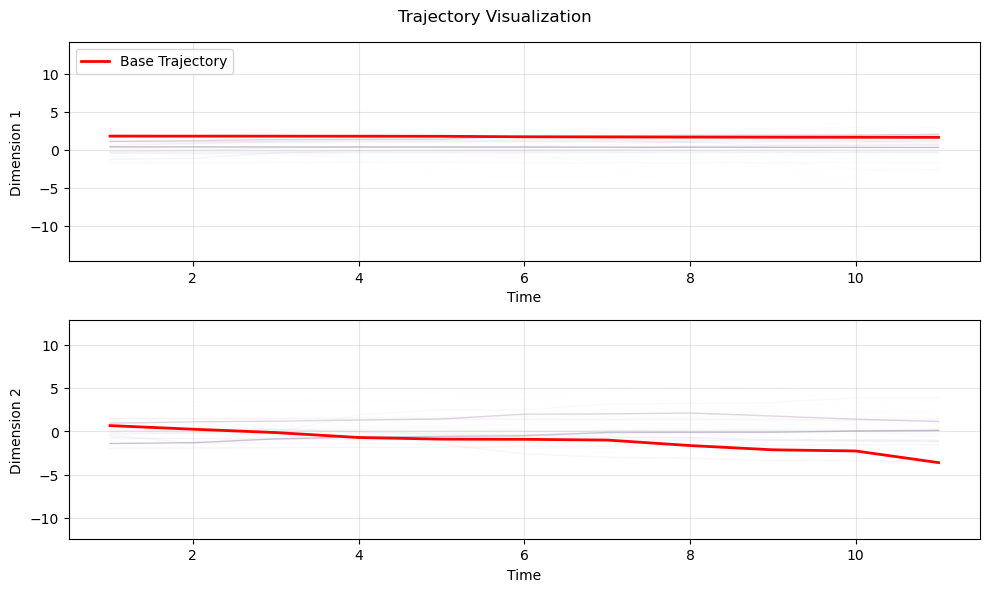

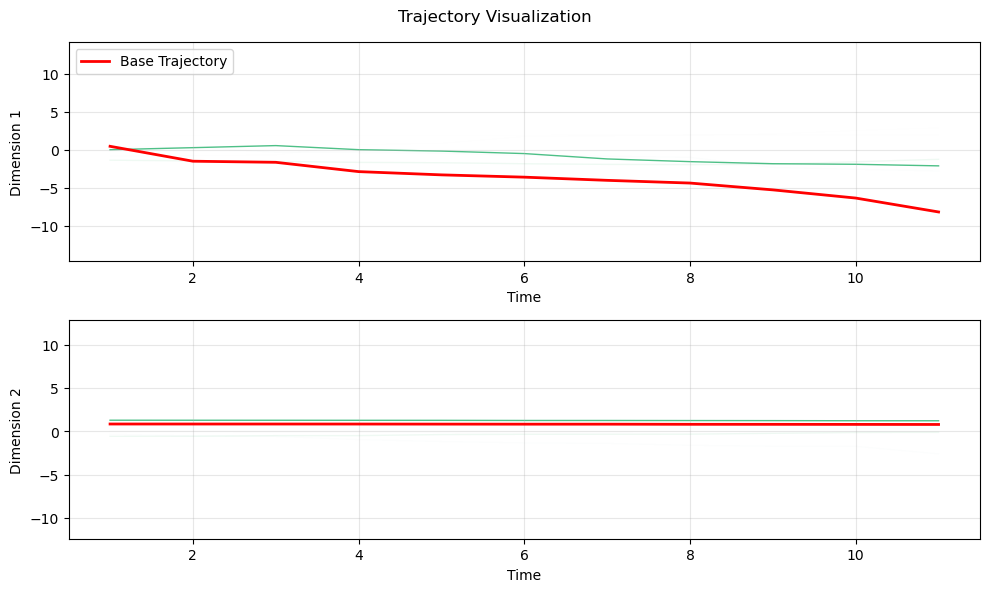

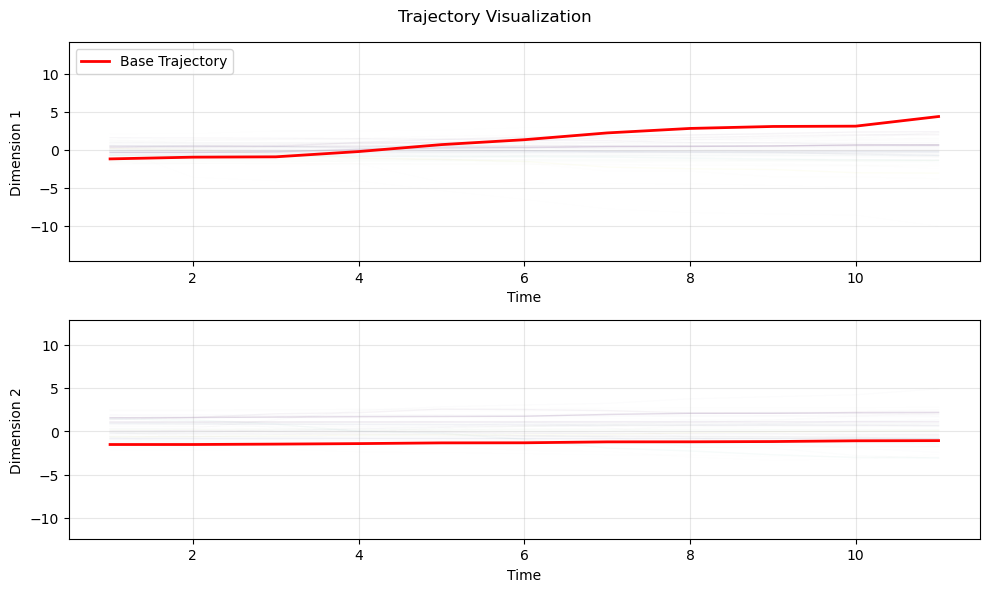

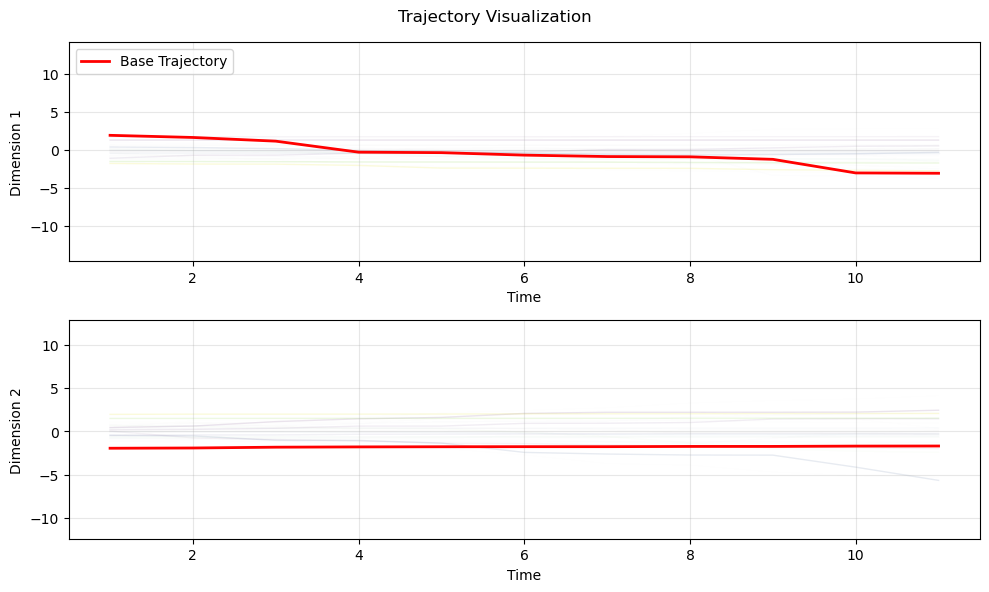

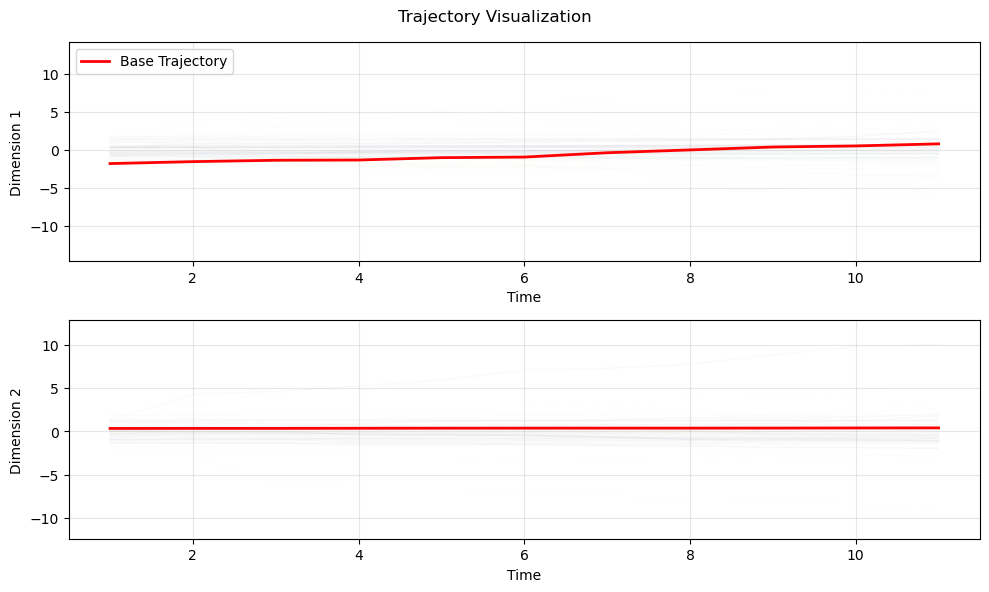

In [11]:
#Retriving some specific trajectories for plotting
def retrive_traj(test_name, base_xi_id=None, phi_id=None):
    global_xi_path = os.path.join("Global_xi_dir", f"{test_name}.pt")
    global_xi = torch.load(global_xi_path)

    phis_path = os.path.join("phis_dir", f"{test_name}.pkl")
    with open(phis_path, 'rb') as f:
        phi_bag_dict = pickle.load(f)
    phi = phi_bag_dict[phi_id][0]

    rho = torch.tanh(phi.quantitative(global_xi, evaluate_at_all_times=False))

    dweights_path = os.path.join("Dweights_dir", f"{test_name}.pt")
    dweights_dict = torch.load(dweights_path)
    dweights = dweights_dict[base_xi_id]

    base_xi_path = os.path.join("Base_xi_dir", f"{test_name}.pt")
    base_xi_dict = torch.load(base_xi_path)
    base_xi = base_xi_dict[base_xi_id]

    return global_xi, dweights, rho, base_xi


test_name = "precomp_E2B"
base_xi_ids = [46, 91, 45, 58, 61]#[86, 64, 9, 12, 50]#[26, 13, 11, 79, 7]##[79, 29, 3, 88, 30]#
phi_id = 10
for base_xi_id in base_xi_ids:
    global_xi, dweights, rho, base_xi = retrive_traj(test_name=test_name, base_xi_id=base_xi_id, phi_id=phi_id)
    
    # Visualize single plot with time evolution
    visualize_trajectories( trajectories=global_xi, robustness_values=rho, dweights=dweights, base_trajectory=base_xi, alpha_range=(0.0, 1.0))
